## ChipSat battery placement optimiser

This notebook optimises the placement of different types of COTS batteries on a ChipSat surface.

Change the constants on the cell below to define the maximum dimensions of the PCB and the maximum area you want covered (to allow for space for other components).

Information about the available options for cells is fetched from an adjacent csv file.

In [49]:
import coloredlogs, logging
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
from IPython.display import HTML, display

# Create a logger object.
logger = logging.getLogger(__name__)

# By default the install() function installs a handler on the root logger,
# this means that log messages from your code and log messages from the
# libraries that you use will all show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)

logger.debug("Welcome to program")

# Maximum X dimension that can be used
AVAILABLE_X = 70
# Maximum Y dimension that can be used
AVAILABLE_Y = 70
# Maximum area that can be used. This can be smaller than AVAILABLE_X * AVAILABLE_Y, if you want to leave some area in your layout for components other than the batteries.
AVAILABLE_AREA = 60 * 60
# Minimum fill ratio of the AVAILABLE_AREA. This is used to prune battery combinations that fill too little of the available area.
FILL_RATIO = 0.40
# Add some padding around the batteries to make assembly easier. One padding unit is added to each one of the four sides of the battery.
PADDING = 1
# Maximum height of battery arrangement.
MAX_HEIGHT = 4.5
# Minimum number of batteries in parallel
REDUNDANCY = 1
# Maximum number of batteries in parallel
MAX_BATTERIES = 4


2024-05-06 17:36:33 pp2233 __main__[14936] DEBUG Welcome to program


In [47]:
df = pd.read_excel('batteries.xlsx').dropna(subset='Capacity').dropna(subset='Product Name')
df = df.apply(pd.to_numeric, errors='ignore')
df.sort_values(by=['Capacity'], inplace=True, ignore_index=True)


df['Dimension Large'] = df['Dimension Large'] + 2 * PADDING
df['Dimension Small'] = df['Dimension Small'] + 2 * PADDING

df['Energy'] = df['Capacity'] * df['Voltage'] /60/60 # energy in Wh
df['Area'] = df['Dimension Large'] * df['Dimension Small']
df['Volume'] = df['Area'] * df['Height']
df['Mass Density'] = df['Energy'] / df['Weight']
df['Area Density'] = df['Energy'] / df['Area']
df['Volume Density'] = df['Energy'] / df['Volume']
df

C:\Users\konstantinos.kanavou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\konstantinos.kanavou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


,Supplier,Product Name,Voltage,Capacity,Dimension Large,Dimension Small,Height,Weight,Connectors,Energy,Area,Volume,Mass Density,Area Density,Volume Density
0,Adafruit,Lithium Ion Polymer Battery - 3.7v 100mAh,3.7,100,33.00,13.50,3.80,3.00,JST-PH,0.102778,445.500,1692.900,0.034259,0.000231,0.000061
1,SparkFun,PRT-13853,3.7,110,27.00,17.00,4.00,8.00,JST-PH,0.113056,459.000,1836.000,0.014132,0.000246,0.000062
2,Adafruit,Lithium Ion Polymer Battery - 3.7v 150mAh,3.7,150,28.02,21.75,3.80,4.65,JST-PH,0.154167,609.435,2315.853,0.033154,0.000253,0.000067
3,Adafruit,Lithium Ion Polymer Battery - 3.7V 350mAh,3.7,350,38.00,21.60,5.20,8.20,JST-PH,0.359722,820.800,4268.160,0.043869,0.000438,0.000084
4,Adafruit,Lithium Ion Polymer Battery Ideal For Feathers...,3.7,400,38.00,19.00,7.80,8.20,JST-PH,0.411111,722.000,5631.600,0.050136,0.000569,0.000073
5,SparkFun,PRT-13851,3.7,400,38.90,28.50,5.00,9.00,JST-PH,0.411111,1108.650,5543.250,0.045679,0.000371,0.000074
6,Adafruit,Lithium Ion Polymer Battery - 3.7v 500mAh,3.7,500,38.00,31.00,4.75,10.50,JST-PH,0.513889,1178.000,5595.500,0.048942,0.000436,0.000092
7,GlobTek,BL0750F5030481S1PCMC,3.7,700,52.50,32.50,5.30,22.00,Molex CLIK-Mate,0.719444,1706.250,9043.125,0.032702,0.000422,0.000080
8,Ansmann,A-Son NP BG1,3.7,900,44.00,37.70,8.60,25.00,Contact,0.925000,1658.800,14265.680,0.037000,0.000558,0.000065
9,Adafruit,Lithium Ion Polymer Battery - 3.7v 1200mAh,3.7,1200,64.00,36.00,5.00,23.00,JST-PH,1.233333,2304.000,11520.000,0.053623,0.000535,0.000107


In [50]:
combinations = [ ]

pbar = tqdm(list(df.iterrows()))

def mysum(combination, attr):
    return df.loc[combination, attr].astype('float').sum()

def investigate_combination(combi):
    start = combi[-1]
    for idx, panel in df.loc[start:].iterrows():
        combi2 = combi.copy()
        combi2.append(idx)

        # Must have one type of battery only
        if len(set(combi2)) > 1:
            continue

        
        area = mysum(combi2, 'Area')

        if area >= AVAILABLE_AREA:
            break
            
        investigate_combination(combi2)
            
        if area < AVAILABLE_AREA * FILL_RATIO:
            continue

        height = df.loc[combi2, 'Height'].astype('float').max()
        if height > MAX_HEIGHT:
            continue

        if len(combi2) < REDUNDANCY:
            continue

        if len(combi2) > MAX_BATTERIES:
            continue
        
        combinations.append({
            "Combination": combi2,
            "Area": area,
            "Energy": mysum(combi2, 'Energy'),
            "Height": height,
            "Weight": mysum(combi2, 'Weight'),
        })
        pbar.set_postfix_str("{} combinations found / depth = {}. {}".format(len(combinations), len(combi2), combi), refresh=True)

for idx, panel in pbar:
    investigate_combination([ idx ])
            
    

  0%|          | 0/12 [00:00<?, ?it/s]

In [39]:
combinations

[{'Combination': [0, 0, 0, 0, 0, 0, 0, 0],
  'Area': 3564.0,
  'Energy': 0.8222222222222223,
  'Height': 3.8,
  'Weight': 24.0},
 {'Combination': [0, 0, 0, 0, 0, 0, 0],
  'Area': 3118.5,
  'Energy': 0.7194444444444444,
  'Height': 3.8,
  'Weight': 21.0},
 {'Combination': [0, 0, 0, 0, 0, 0],
  'Area': 2673.0,
  'Energy': 0.6166666666666667,
  'Height': 3.8,
  'Weight': 18.0},
 {'Combination': [0, 0, 0, 0, 0],
  'Area': 2227.5,
  'Energy': 0.513888888888889,
  'Height': 3.8,
  'Weight': 15.0},
 {'Combination': [0, 0, 0, 0],
  'Area': 1782.0,
  'Energy': 0.41111111111111115,
  'Height': 3.8,
  'Weight': 12.0},
 {'Combination': [1, 1, 1, 1, 1, 1, 1],
  'Area': 3213.0,
  'Energy': 0.7913888888888889,
  'Height': 4.0,
  'Weight': 56.0},
 {'Combination': [1, 1, 1, 1, 1, 1],
  'Area': 2754.0,
  'Energy': 0.6783333333333333,
  'Height': 4.0,
  'Weight': 48.0},
 {'Combination': [1, 1, 1, 1, 1],
  'Area': 2295.0,
  'Energy': 0.5652777777777778,
  'Height': 4.0,
  'Weight': 40.0},
 {'Combination':

In [51]:
parsed_combinations = pd.DataFrame(combinations)
pc = parsed_combinations
pc['Fill Ratio'] = pc['Area'] / AVAILABLE_AREA
pc['Empty Ratio'] = 1-pc['Fill Ratio']
pc['Area Density'] = pc['Energy'] / pc['Area']
pc['Volume Density'] = pc['Energy'] / (pc['Area'] * pc['Height'])
pc['Mass Density'] = pc['Energy'] / pc['Weight']
pc

,Combination,Area,Energy,Height,Weight,Fill Ratio,Empty Ratio,Area Density,Volume Density,Mass Density
0,"[0, 0, 0, 0]",1782.000,0.411111,3.8,12.00,0.495000,0.505000,0.000231,0.000061,0.034259
1,"[1, 1, 1, 1]",1836.000,0.452222,4.0,32.00,0.510000,0.490000,0.000246,0.000062,0.014132
2,"[2, 2, 2, 2]",2437.740,0.616667,3.8,18.60,0.677150,0.322850,0.000253,0.000067,0.033154
3,"[2, 2, 2]",1828.305,0.462500,3.8,13.95,0.507862,0.492138,0.000253,0.000067,0.033154


In [52]:
#pc.sort_values(by=['Power', 'Empty Ratio'], inplace=True, ascending=False)
pc.sort_values(by=['Energy', 'Empty Ratio'], inplace=True, ascending=False)
pc

,Combination,Area,Energy,Height,Weight,Fill Ratio,Empty Ratio,Area Density,Volume Density,Mass Density
2,"[2, 2, 2, 2]",2437.740,0.616667,3.8,18.60,0.677150,0.322850,0.000253,0.000067,0.033154
3,"[2, 2, 2]",1828.305,0.462500,3.8,13.95,0.507862,0.492138,0.000253,0.000067,0.033154
1,"[1, 1, 1, 1]",1836.000,0.452222,4.0,32.00,0.510000,0.490000,0.000246,0.000062,0.014132
0,"[0, 0, 0, 0]",1782.000,0.411111,3.8,12.00,0.495000,0.505000,0.000231,0.000061,0.034259


In [54]:
import rpack
#import rpack.misc.recstat

finds = 0

for idx, combi in pc.iterrows():
    combination = combi['Combination']
    #print(combination)
    
    if combi['Area'] >= AVAILABLE_AREA:
        print("Combination {} area {:.2f} > {:.2f}, ignored".format(combination, combi['Area'], AVAILABLE_AREA))
        continue
        
    if len(Counter(combination)) > 1:
        print("Combination {} has {} duplicates, ignored".format(combination, len(Counter(combination))))
        continue
    
    panels = df.iloc[combination]
    panels_orig = panels
    panels = panels[['Dimension Large', 'Dimension Small']]
    panels = list(panels.astype('int').itertuples(index=False, name=None))
    
    try:
        positions = rpack.pack(panels, max_width=AVAILABLE_X, max_height=AVAILABLE_Y)
    except:
        try:
            positions = rpack.pack(panels, max_width=AVAILABLE_Y, max_height=AVAILABLE_X)
        except Exception as e:
            print("Combination {} cannot be packed because {}".format(combination, e))
            continue
            
    print(panels)
    print(positions)

    bbox = rpack.bbox_size(panels, positions)
    density = rpack.packing_density(panels, positions)

    print("Bounding Box = {}, density = {}".format(bbox, density))

    print(len(Counter(combination)))
    print("Found on combination #{}".format(idx))
    display(combi)
    display(panels_orig)
    finds += 1

    if finds >= 1:
        break
    


[(28, 21), (28, 21), (28, 21), (28, 21)]
[(0, 21), (28, 0), (28, 21), (0, 0)]
Bounding Box = (56, 42), density = 1.0
1
Found on combination #2


Combination       [2, 2, 2, 2]
Area                   2437.74
Energy                0.616667
Height                     3.8
Weight                    18.6
Fill Ratio             0.67715
Empty Ratio            0.32285
Area Density          0.000253
Volume Density        0.000067
Mass Density          0.033154
Name: 2, dtype: object

,Supplier,Product Name,Voltage,Capacity,Dimension Large,Dimension Small,Height,Weight,Connectors,Energy,Area,Volume,Mass Density,Area Density,Volume Density
2,Adafruit,Lithium Ion Polymer Battery - 3.7v 150mAh,3.7,150,28.02,21.75,3.8,4.65,JST-PH,0.154167,609.435,2315.853,0.033154,0.000253,0.000067
2,Adafruit,Lithium Ion Polymer Battery - 3.7v 150mAh,3.7,150,28.02,21.75,3.8,4.65,JST-PH,0.154167,609.435,2315.853,0.033154,0.000253,0.000067
2,Adafruit,Lithium Ion Polymer Battery - 3.7v 150mAh,3.7,150,28.02,21.75,3.8,4.65,JST-PH,0.154167,609.435,2315.853,0.033154,0.000253,0.000067
2,Adafruit,Lithium Ion Polymer Battery - 3.7v 150mAh,3.7,150,28.02,21.75,3.8,4.65,JST-PH,0.154167,609.435,2315.853,0.033154,0.000253,0.000067


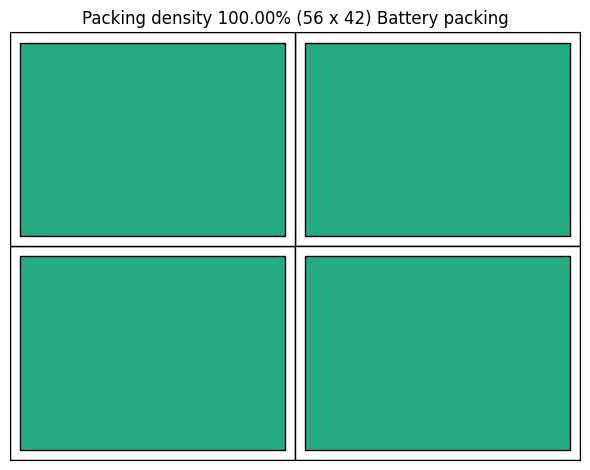

Supplier                                            Adafruit
Product Name       Lithium Ion Polymer Battery - 3.7v 150mAh
Voltage                                                  3.7
Capacity                                                 150
Dimension Large                                        28.02
Dimension Small                                        21.75
Height                                                   3.8
Weight                                                  4.65
Connectors                                            JST-PH
Energy                                              0.154167
Area                                                 609.435
Volume                                              2315.853
Mass Density                                        0.033154
Area Density                                        0.000253
Volume Density                                      0.000067
Name: 2, dtype: object


In [68]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import  matplotlib.animation as mani

def rectangle_color(w, h):
    r = min(w, h)/max(w, h)/2
    if h < w:
        r = 1 - r
    r = r/2 + 0.3
    return plt.get_cmap('viridis')(r)

class PlotPacking:

    def __init__(self, rec, pos, gridlines=False, title='', trim=False):
        """Initialization of PlotPacking"""
        self.rec = rec
        self.pos = pos
        self.gridlines = gridlines
        self.index = None
        self.encl_w, self.encl_h = rpack.enclosing_size(rec, pos)
        self.density = sum(w*h for w, h in rec)/(self.encl_w*self.encl_h)
        if trim:
            self.fig = plt.figure(figsize=(6, 6*self.encl_h/self.encl_w))
            self.ax = self.fig.add_axes([0.01, 0.01, 0.98, 0.98])
        else:
            self.fig, self.ax = plt.subplots(tight_layout=True)
            self.ax.set_aspect('equal')
        self.ax.invert_yaxis()
        self.ax.set_xlim([0, self.encl_w])
        self.ax.set_ylim([self.encl_h, 0])
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        if title and not trim:
            self.ax.set_title(
                f'Packing density {100*self.density:.2f}% '
                f'({self.encl_w} x {self.encl_h})' + title)

    def feed(self, *args):
        artists = list()
        if self.index is None:
            self.index = 0
            return [self.ax]
        try:
            w, h = self.rec[self.index]
            x, y = self.pos[self.index]
        except IndexError:
            return []
        else:
            p = patches.Rectangle(
                (x, y), w, h,
                edgecolor='k',
                facecolor='w'
            )
            self.ax.add_patch(p)
            artists.append(p)
            ps = patches.Rectangle(
                (x + PADDING, y + PADDING), w - 2*PADDING, h - 2*PADDING,
                edgecolor='k',
                facecolor=rectangle_color(w, h)
            )
            self.ax.add_patch(ps)
            artists.append(ps)
            if self.gridlines:
                hline = self.ax.axhline(y+h, color='k', linestyle='-', linewidth=0.5)
                vline = self.ax.axvline(x+w, color='k', linestyle='-', linewidth=0.5)
                artists.append(hline)
                artists.append(vline)
            self.index += 1
            return artists
    
    def display(self):
        plt.show()

pp = PlotPacking(panels, positions, title=' Battery packing')
while len(pp.feed()) >= 1:
    pass
pp.display()

print(df.loc[combination[0]])